In [2]:
print('Hello world!')

Hello world!


In [2]:
### Import libraries
import numpy as np                  # For doing math
import matplotlib.pyplot as plt     # For plotting
import matplotlib.dates as mdates   # For formatting dates when plotting
import xarray as xr                 # For dealing with netCDF data
import cartopy.crs as ccrs          # For plotting maps
import cartopy.feature as cfeature  # For plotting maps
import pandas as pd                 # A quick way to deal with time stamps
import cartopy
import matplotlib
from netCDF4 import Dataset
from xarray import DataArray
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
import metpy

#import basemap
import geopandas as gpd
#import descartes
import wrf


import dask.base
from dask.base import tokenize
import dask



print('Done importing libraries')

Done importing libraries


In [3]:
# Read in ET perimeter data

file_path = '/projects/tita6191/fire/east_troublesome_perimeter/OBJECTID_11.gpkg'
filenames = []

files_list = []
for f in filenames:
    file_tmp = file_path + f
    files_list.append(file_tmp)
    
ET = gpd.read_file(file_path)
ET
#ET.boundary.plot()

#print(ET.crs)

#ET.geom_type
#print(ET.bounds)
#points = ET["geometry"].centroid
#print(points)
#mycoordslist = [list(x.exterior.coords) for x in geom.geoms]

#ET = ET.set_index("IncidentNa")
#print(ET.geometry.values)
#print(ET.Latiutude)

,OBJECTID,GDB_ARCHIV,IncidentNa,FeatureCat,MapMethod,Comments,GISAcres,DeleteThis,Label,FeatureAcc,...,LocalIncid,IRWINID,GeometryID,GlobalID,GDB_FROM_D,GDB_TO_DAT,EGP_OID,SHAPE_Leng,SHAPE_Area,geometry
0,93248,212960,East Troublesome,Wildfire Daily Fire Perimeter,Mixed Methods,None,125678.193563,No,None,Public,...,000408,b53d1cf4-c52b-40a9-80f3-dbde35f6adc9,None,{0D1B55EB-9790-4ABE-A21D-39FD91F580DC},2020-10-22,2020-10-22,0,2.996584,0.05382,"MULTIPOLYGON (((-105.74920 40.32030, -105.7500..."


## Plot the domain (and the fire spread)

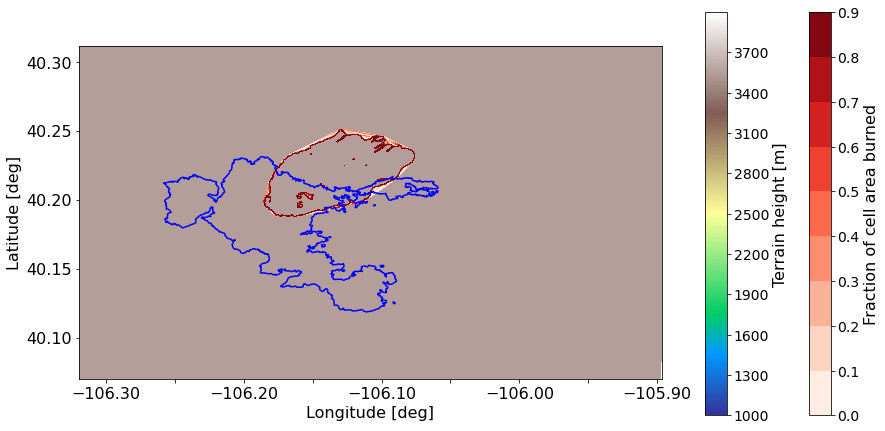

In [4]:
# Plot the terrain
# Now, lets plot with the fire perimeter on top.
font_size = 16

outer = xr.open_dataset('/projects/tita6191/fire/01_geosmoothing/geogrid/geo_em.d01.nc')
inner = xr.open_dataset('/projects/tita6191/fire/01_geosmoothing/geogrid/geo_em.d02.nc')

#outer = xr.open_dataset('/projects/tita6191/wrf_tutorial/fire_tutorial/geo_em.d01.nc')
#inner = xr.open_dataset('/projects/tita6191/wrf_tutorial/fire_tutorial/geo_em.d02.nc')
#fire = xr.open_dataset('/projects/tita6191/wrf_tutorial/fire_tutorial/run/run_outputs/wrfout_d02_2020-10-22_10:00:00')
fire = xr.open_dataset('/projects/tita6191/fire/01_geosmoothing/run/1-2-1/run_outputs/wrfout_d02_2020-10-22_10:00:00')
#fire = xr.open_dataset('/pl/active/courses/2021_fall/ATOC_NWP/2021_tutorial_materials/east_troublesome/run_outputs/wrfout_d02_2020-10-22_10:00:00')


lats = inner['XLAT_M'].isel(Time=0)    # Note: we must index-select Time=0 because plots expect 2D data (lat-lon)
longs = inner['XLONG_M'].isel(Time=0)
heights = inner['HGT_M'].isel(Time=0)

min_lat = lats.values.min()
max_lat = lats.values.max()
min_lon = longs.values.min()
max_lon = longs.values.max()

fig, ax = plt.subplots(1,1,figsize=(12,8), sharex=True, sharey=True)
terrain_levels = np.arange(1000, 4000, 1)
fire_levels = np.arange(0,1,0.1)

im = ax.contourf(inner['XLONG_M'].values[0, :, :],
    inner['XLAT_M'].values[0, :, :],
    inner['HGT_M'].values[0, :, :], terrain_levels,
    cmap=plt.cm.terrain)


fire_longs = fire['FXLONG'].values[0, :, :]
fire_lats = fire['FXLAT'].values[0, :, :]
fire_area = fire['FIRE_AREA'].values[0, :, :]

fire_longs = fire_longs[fire_area>0]
fire_lats = fire_lats[fire_area>0]
fire_area = fire_area[fire_area>0]

im2 = ax.tricontourf(fire_longs, fire_lats, fire_area, fire_levels, cmap = 'Reds')
#ax.contourf(fire['FXLONG'].values[0, :, :],
#    fire['FXLAT'].values[0, :, :],
#    fire['FIRE_AREA'].values[0, :, :], fire_levels)#, locator = MaxNLocator(prune = 'lower'))

ET = gpd.read_file('/projects/tita6191/fire/east_troublesome_perimeter/OBJECTID_5.gpkg')
ET.boundary.plot(ax=ax, color='b')

ax.set_ylabel("Latitude [deg]", fontsize= font_size)
ax.set_xlabel("Longitude [deg]", fontsize= font_size)
#ax.set_extent(MAP_BOUNDS)

plt.xlim([min_lon, max_lon])
plt.ylim([min_lat, max_lat])

ax.tick_params(axis='x', labelsize= font_size)
ax.tick_params(axis='y', labelsize= font_size)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
cbar_ax2 = fig.add_axes([0.97, 0.15, 0.025, 0.7])
                                                                 
cbar = fig.colorbar(im, cax=cbar_ax)
cbar2 = fig.colorbar(im2, cax=cbar_ax2)

cbar.set_label("Terrain height [m]",fontsize= font_size)
cbar.ax.tick_params(labelsize=font_size-2)
cbar2.set_label("Fraction of cell area burned",fontsize= font_size)
cbar2.ax.tick_params(labelsize=font_size-2)

plt.show()

In [6]:
outer = xr.open_dataset('/projects/tita6191/wrf_tutorial/fire_tutorial/geo_em.d01.nc')
#fire = xr.open_dataset('/pl/active/courses/2021_fall/ATOC_NWP/2021_tutorial_materials/east_troublesome/run_outputs/wrfout_d02_2020-10-22_06:00:00')
#fire = fire.where(fire['FXLAT'] != 0)

# List of the filenames
filenames = ['wrfout_d02_2020-10-20_22:00:00','wrfout_d02_2020-10-20_23:00:00','wrfout_d02_2020-10-21_00:00:00',\
            'wrfout_d02_2020-10-21_01:00:00','wrfout_d02_2020-10-21_02:00:00','wrfout_d02_2020-10-21_03:00:00','wrfout_d02_2020-10-21_04:00:00',\
            'wrfout_d02_2020-10-21_05:00:00','wrfout_d02_2020-10-21_06:00:00','wrfout_d02_2020-10-21_07:00:00','wrfout_d02_2020-10-21_08:00:00',\
            'wrfout_d02_2020-10-21_09:00:00','wrfout_d02_2020-10-21_10:00:00','wrfout_d02_2020-10-21_11:00:00','wrfout_d02_2020-10-21_12:00:00',\
            'wrfout_d02_2020-10-21_13:00:00','wrfout_d02_2020-10-21_14:00:00','wrfout_d02_2020-10-21_15:00:00','wrfout_d02_2020-10-21_16:00:00',\
            'wrfout_d02_2020-10-21_17:00:00','wrfout_d02_2020-10-21_18:00:00','wrfout_d02_2020-10-21_19:00:00','wrfout_d02_2020-10-21_20:00:00',\
            'wrfout_d02_2020-10-21_21:00:00','wrfout_d02_2020-10-21_22:00:00','wrfout_d02_2020-10-21_23:00:00','wrfout_d02_2020-10-22_00:00:00',\
            'wrfout_d02_2020-10-22_01:00:00','wrfout_d02_2020-10-22_02:00:00','wrfout_d02_2020-10-22_03:00:00','wrfout_d02_2020-10-22_04:00:00',\
            'wrfout_d02_2020-10-22_05:00:00','wrfout_d02_2020-10-22_06:00:00','wrfout_d02_2020-10-22_07:00:00','wrfout_d02_2020-10-22_08:00:00',\
            'wrfout_d02_2020-10-22_09:00:00','wrfout_d02_2020-10-22_10:00:00']

file_path_control = '/projects/tita6191/wrf_tutorial/fire_tutorial/run/run_outputs/'
file_path_smooth = '/projects/tita6191/fire/01_geosmoothing/run/1-2-1/run_outputs/'

files_list_control = []
for f in filenames:
    file_tmp = file_path_control + f
    files_list_control.append(file_tmp)
    
print(files_list_control[0])
fire_control = xr.open_mfdataset(files_list_control,combine='nested',concat_dim='Time')

files_list_smooth = []
for f in filenames:
    file_tmp = file_path_smooth + f
    files_list_smooth.append(file_tmp)
fire_smooth = xr.open_mfdataset(files_list_smooth,combine='nested',concat_dim='Time')

/projects/tita6191/wrf_tutorial/fire_tutorial/run/run_outputs/wrfout_d02_2020-10-20_22:00:00


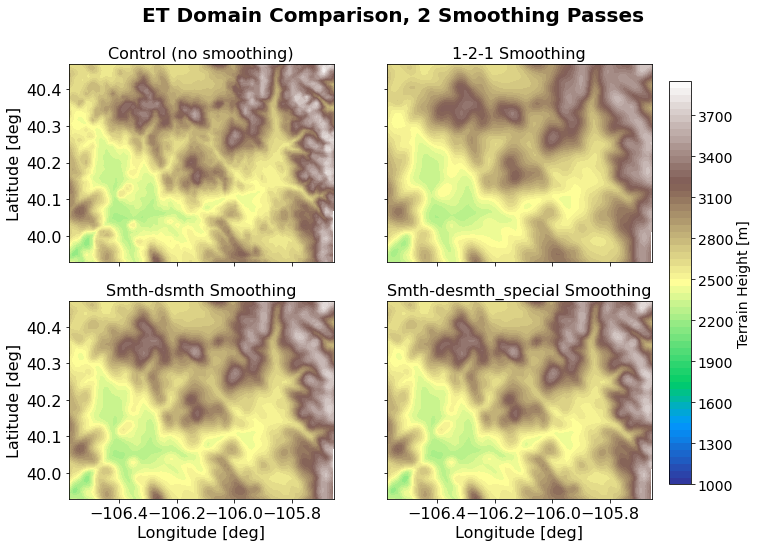

In [7]:
# Plot the terrain
num_passes = 2

control = xr.open_dataset('/projects/tita6191/wrf_tutorial/fire_tutorial/geo_em.d01.nc')
one2one = xr.open_dataset('/projects/tita6191/fire/01_geosmoothing/geogrid/1-2-1/geo_em.d01.nc.' + str(num_passes))
smth = xr.open_dataset('/projects/tita6191/fire/01_geosmoothing/geogrid/smth-desmth/geo_em.d01.nc.' + str(num_passes))
spcl = xr.open_dataset('/projects/tita6191/fire/01_geosmoothing/geogrid/smth-desmth_special/geo_em.d01.nc.' + str(num_passes))
#inner = xr.open_dataset('/projects/tita6191/wrf_tutorial/fire_tutorial/geo_em.d02.nc')

fig, ax = plt.subplots(2,2,figsize=(12,8), sharex=True, sharey=True)
c_levels = np.arange(1000, 4000, 50)
                                                                 
im1 = ax[0,0].contourf(control['XLONG_M'].values[0, :, :],
    control['XLAT_M'].values[0, :, :],
    control['HGT_M'].values[0, :, :], c_levels,
    cmap=plt.cm.terrain)

im2 = ax[0,1].contourf(one2one['XLONG_M'].values[0, :, :],
    one2one['XLAT_M'].values[0, :, :],
    one2one['HGT_M'].values[0, :, :], c_levels,
    cmap=plt.cm.terrain)

im3 = ax[1,0].contourf(smth['XLONG_M'].values[0, :, :],
    smth['XLAT_M'].values[0, :, :],
    smth['HGT_M'].values[0, :, :], c_levels,
    cmap=plt.cm.terrain)

im4 = ax[1,1].contourf(spcl['XLONG_M'].values[0, :, :],
    spcl['XLAT_M'].values[0, :, :],
    spcl['HGT_M'].values[0, :, :], c_levels,
    cmap=plt.cm.terrain)

font_size = 16
ax[0, 0].set_title('Control (no smoothing)', fontsize = font_size)
ax[0, 1].set_title('1-2-1 Smoothing', fontsize = font_size)
ax[1, 0].set_title('Smth-dsmth Smoothing', fontsize = font_size)
ax[1, 1].set_title('Smth-desmth_special Smoothing', fontsize = font_size)

for axs in ax.flat:
    axs.set(xlabel='Longitude [deg]', ylabel='Latitude [deg]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for axs in ax.flat:
    axs.label_outer()

#ax.set_ylabel("Latitude [deg]")
#ax.set_xlabel("Longitude [deg]")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.025, 0.7])
                                                                 
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label("Terrain Height [m]", fontsize = font_size - 2)
cbar.ax.tick_params(labelsize=font_size - 2)

fig.suptitle('ET Domain Comparison, ' + str(num_passes) + ' Smoothing Passes', fontsize = font_size + 4, fontweight ='bold')

ax[1,1].tick_params(axis='x', labelsize= font_size)
ax[1,0].tick_params(axis='x', labelsize= font_size)
ax[1,0].tick_params(axis='y', labelsize= font_size)
ax[0,0].tick_params(axis='y', labelsize= font_size)

ax[1,1].set_xlabel('Longitude [deg]', fontsize = font_size)
ax[1,0].set_xlabel('Longitude [deg]', fontsize = font_size)
ax[1,0].set_ylabel('Latitude [deg]', fontsize = font_size)
ax[0,0].set_ylabel('Latitude [deg]', fontsize = font_size)

plt.show()

## Plot windspeed

In [ ]:
# Extract the latitudes and longitudes of the data
lats = df['XLAT'].isel(Time=0)    # Note: we must index-select Time=0 because plots expect 2D data (lat-lon)
longs = df['XLONG'].isel(Time=0)
# Identify the maximum and minimum lats and longs for making a pretty plot
min_lat = lats.values.min()
max_lat = lats.values.max()
min_lon = longs.values.min()
max_lon = longs.values.max()
MAP_BOUNDS = [min_lon, max_lon, min_lat, max_lat]

# Extract the 10-m u and v wind speed 
u10 = df['U10']
v10 = df['V10']

# Ooops, that's not enough - we have to combine U10 and V10 to get wind speed
wind_speed = np.sqrt(df['U10']**2 + df['V10']**2) # Didn't need to do the lines above - can extract and combine together

print(np.shape(wind_speed))  # Notice that this is time x lat x long

#########
# Specify time indices for the plots:
# Play with these two numbers to understand how time indexing works with xarray
first_index = 20 # 
second_index = 35 # What is the maximum time_index you can use with this set of files?

### Visualize variable of interest at two different times
## Set up the figure and axis, cartopy style
fig = plt.figure(figsize=(20,8))

# Left plot - change the order and numbering of 1, 2, 1 to put plots on top of each other instead 
# of next to each other
ax1 = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree())
ax1.set_extent(MAP_BOUNDS) # limit the extent to where we have data 

# Right plot
ax2 = fig.add_subplot(1,2,2, projection=ccrs.PlateCarree())
ax2.set_extent(MAP_BOUNDS)

## Set up colorbar values
min_value = 0 # m/s  -- change this if you're plotting something other than 10-m winds
max_value = 20 # m/s  -- change this if you're plotting something other than 10-m winds
num_colors = 11 # number of colors in the color bar
ticks = np.linspace(min_value,max_value,num_colors)

# Filled-contour plots - these are of wind_speed, but you may plot something else
im1 = ax1.contourf(longs, lats, wind_speed.isel(Time=first_index), ticks)
im2 = ax2.contourf(longs, lats, wind_speed.isel(Time=second_index), ticks)

# Make a pretty color bar and put it in a nice spot
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.1, 0.15, 0.7, 0.03]) # along the bottom
cbar = fig.colorbar(im1, cax=cbar_ax, ticks=ticks, orientation="horizontal") # along the bottom
cbar.set_label('10-m Wind Speed [m/s]', fontsize=14) # label it please
cbar.ax.tick_params(labelsize=14)

# Necessary labels for the left plot
ax1.xaxis.set_visible(True)
ax1.yaxis.set_visible(True)
ax1.tick_params(labelsize=12)
ax1.set_xlabel("Longitude", fontsize=12)
ax1.set_ylabel("Latitude", fontsize=12)
ax1.xaxis.set_major_locator(MaxNLocator(6))

# Use python's awesome datetime functionality to convert the WRF Time to something readable
# where strftime (google it) defines the format of the label
ax1.set_title(pd.to_datetime(df['XTIME'].values[first_index]).strftime('%Y-%m-%d %H:%M') , fontsize=14)


# Necessary labels for the right plot
ax2.xaxis.set_visible(True)
# ax2.yaxis.set_visible(True)
ax2.tick_params(labelsize=12)
ax2.xaxis.set_major_locator(MaxNLocator(6))

ax2.set_xlabel("Longitude", fontsize=12)
# ax2.set_ylabel("Latitude", fontsize=14)  # commented out to avoid redundant information
ax2.set_title(pd.to_datetime(df['XTIME'].values[second_index]).strftime('%Y-%m-%d %H:%M') , fontsize=14)

# ax1.scatter([-87.442085], [26.4], color='r')
# ax2.scatter([-87.442085], [26.4], color='r')



plt.gcf().subplots_adjust(bottom=0.15)
plt.show()

## Using WRF-Python to check out a pressure plot as a test:

In [ ]:
'''
# Extract the latitudes and longitudes of the data
lats = df['XLAT'].isel(Time=0)    # Note: we must index-select Time=0 because plots expect 2D data (lat-lon)
longs = df['XLONG'].isel(Time=0)
# Identify the maximum and minimum lats and longs for making a pretty plot
min_lat = lats.values.min()
max_lat = lats.values.max()
min_lon = longs.values.min()
max_lon = longs.values.max()
MAP_BOUNDS = [min_lon, max_lon, min_lat, max_lat]

wind_speed= np.sqrt(df['U10']**2 + df['V10']**2) # Didn't need to do the lines above - can extract and combine together
fire_spread = df['BURNT_AREA_DT']
fire_area = df['FIRE_AREA']
fire_longs = df['FXLONG']
fire_lats = df['FXLAT']


inner = xr.open_dataset('/projects/tita6191/wrf_tutorial/fire_tutorial/geo_em.d02.nc')
fig, ax = plt.subplots(1,1,figsize=(12,8), sharex=True, sharey=True)
c_levels = np.arange(-1000, 5000, 250)
'''

from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

# Open the NetCDF file
ncfile = Dataset("/pl/active/courses/2021_fall/ATOC_NWP/2021_tutorial_materials/east_troublesome/run_outputs/wrfout_d02_2020-10-22_06:00:00")

# Get the sea level pressure
slp = getvar(ncfile, "slp")
print(slp)

# Smooth the sea level pressure since it tends to be noisy near the
# mountains
smooth_slp = smooth2d(slp, 3, cenweight=4)

# Get the latitude and longitude points
lats, lons = latlon_coords(slp)

# Get the cartopy mapping object
cart_proj = get_cartopy(slp)

# Create a figure
fig = plt.figure(figsize=(12,6))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

# Make the contour outlines and filled contours for the smoothed sea level
# pressure.
plt.contour(to_np(lons), to_np(lats), to_np(smooth_slp), 10, colors="black",
            transform=crs.PlateCarree())
plt.contourf(to_np(lons), to_np(lats), to_np(smooth_slp), 10,
             transform=crs.PlateCarree(),
             cmap=get_cmap("jet"))

# Add a color bar
plt.colorbar(ax=ax, shrink=.98)

# Set the map bounds
ax.set_xlim(cartopy_xlim(smooth_slp))
ax.set_ylim(cartopy_ylim(smooth_slp))

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")

plt.title("Sea Level Pressure (hPa)")

plt.show()

## Plotting windspeed cross sections

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from netCDF4 import Dataset
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker


from wrf import to_np, getvar, CoordPair, vertcross

font_size = 14

# Open the NetCDF file
filename = "/pl/active/courses/2021_fall/ATOC_NWP/2021_tutorial_materials/east_troublesome/run_outputs/wrfout_d02_2020-10-22_04:00:00"
ncfile = Dataset(filename)

# Extract the model height and wind speed
z = getvar(ncfile, "z")

wspd =  getvar(ncfile, "wa", units="mps")[:,:]
print(np.shape(wspd))

# Create the start point and end point for the cross section
start_point = CoordPair(lat=40.20, lon=-106.20)
end_point = CoordPair(lat=40.20, lon=-106.10)

# Compute the vertical cross-section interpolation.  Also, include the
# lat/lon points along the cross-section.
wspd_cross = vertcross(wspd, z, wrfin=ncfile, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

# Create the figure
fig = plt.figure(figsize=(12,9))
ax = plt.axes()

# Make the contour plot
wspd_contours = ax.contourf(to_np(wspd_cross), cmap=get_cmap("bwr"))

# Add the color bar
cbar = plt.colorbar(wspd_contours, ax=ax)
cbar.set_label("Vertical wind speed [m/s]", fontsize = font_size)
cbar.ax.tick_params(labelsize=font_size - 2)

# Set the x-ticks to use latitude and longitude labels.
coord_pairs = to_np(wspd_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_xticks(x_ticks[::10])
ax.set_xticklabels(x_labels[::10], rotation=25, fontsize=font_size)

# Set the y-ticks to be height.
#vert_vals = to_np(wspd_cross.coords["vertical"])
#v_ticks = np.arange(vert_vals.shape[0])
#ax.set_yticks(v_ticks[::20])
#ax.set_yticklabels(vert_vals[::20]/1e3, fontsize=font_size)

# Personal fix for axes
regular_vals = np.arange(0, 11e3, 2e3/20)
regular_ticks = np.arange(len(regular_vals))
ax.set_yticks(regular_ticks[::20])
ax.set_yticklabels(regular_ticks[::20]/10, fontsize=font_size)

#ax.set_ylim([2000, 10000])

# Set the x-axis and  y-axis labels
ax.set_xlabel("Latitude, Longitude", fontsize=font_size)
ax.set_ylabel("Height (km)", fontsize=font_size)

plt.title("Cross Section of Vertical Wind Speed (m/s)", fontsize = font_size)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from netCDF4 import Dataset

from wrf import to_np, getvar, CoordPair, vertcross

font_size = 14

# Open the NetCDF file
filename = '/pl/active/courses/2021_fall/ATOC_NWP/2021_tutorial_materials/east_troublesome/run_outputs/wrfout_d02_2020-10-22_04:00:00'
ncfile = Dataset(filename)

# Extract the model height and wind speed
z = getvar(ncfile, "z")
wspd =  getvar(ncfile, "uvmet_wspd_wdir", units="mps")[0,:]

# Create the start point and end point for the cross section
start_point = CoordPair(lat=40.20, lon=-106.20)
end_point = CoordPair(lat=40.20, lon=-106.10)

# Compute the vertical cross-section interpolation.  Also, include the
# lat/lon points along the cross-section.
wspd_cross = vertcross(wspd, z, wrfin=ncfile, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

# Create the figure
fig = plt.figure(figsize=(12,9))
ax = plt.axes()

# Make the contour plot
wspd_contours = ax.contourf(to_np(wspd_cross), cmap=get_cmap("inferno"))

# Add the color bar
cbar = plt.colorbar(wspd_contours, ax=ax)
cbar.set_label("Horizontal wind speed [m/s]", fontsize = font_size)
cbar.ax.tick_params(labelsize=font_size - 2)

# Set the x-ticks to use latitude and longitude labels.
coord_pairs = to_np(wspd_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_xticks(x_ticks[::20])
ax.set_xticklabels(x_labels[::20], rotation=20, fontsize=font_size)

# Set the y-ticks to be height.
vert_vals = to_np(wspd_cross.coords["vertical"])
v_ticks = np.arange(vert_vals.shape[0])
#print(vert_vals)
#print(np.shape(vert_vals))
#print(z)


#ax.set_yticks(v_ticks[::20])
#ax.set_yticklabels(vert_vals[::20]/1e3, fontsize=font_size)

# Personal fix for axes
regular_vals = np.arange(0, 11e3, 2e3/20)
regular_ticks = np.arange(len(regular_vals))
ax.set_yticks(regular_ticks[::20])
ax.set_yticklabels(regular_ticks[::20]/10, fontsize=font_size)

# Set the x-axis and  y-axis labels
ax.set_xlabel("Latitude, Longitude", fontsize=font_size)
ax.set_ylabel("Height (km)", fontsize=font_size)

plt.title("Cross Section of Horizontal Wind Speed (m/s)", fontsize = font_size)

plt.show()

## Maximum wind speed over time

In [ ]:
# Plot a time series of maximum wind speed

# Open not just one file, but all files in the directory

# List of the filenames
filenames = ['wrfout_d02_2020-10-20_22:00:00','wrfout_d02_2020-10-20_23:00:00','wrfout_d02_2020-10-21_00:00:00',\
                'wrfout_d02_2020-10-21_01:00:00','wrfout_d02_2020-10-21_02:00:00','wrfout_d02_2020-10-21_03:00:00','wrfout_d02_2020-10-21_04:00:00',\
            'wrfout_d02_2020-10-21_05:00:00','wrfout_d02_2020-10-21_06:00:00','wrfout_d02_2020-10-21_07:00:00','wrfout_d02_2020-10-21_08:00:00',\
            'wrfout_d02_2020-10-21_09:00:00','wrfout_d02_2020-10-21_10:00:00','wrfout_d02_2020-10-21_11:00:00','wrfout_d02_2020-10-21_12:00:00',\
             'wrfout_d02_2020-10-21_13:00:00','wrfout_d02_2020-10-21_14:00:00','wrfout_d02_2020-10-21_15:00:00','wrfout_d02_2020-10-21_16:00:00',\
             'wrfout_d02_2020-10-21_17:00:00','wrfout_d02_2020-10-21_18:00:00', 'wrfout_d02_2020-10-21_19:00:00','wrfout_d02_2020-10-21_20:00:00',\
             'wrfout_d02_2020-10-21_21:00:00','wrfout_d02_2020-10-21_22:00:00','wrfout_d02_2020-10-21_23:00:00','wrfout_d02_2020-10-22_00:00:00',\
             'wrfout_d02_2020-10-22_01:00:00','wrfout_d02_2020-10-22_02:00:00','wrfout_d02_2020-10-22_03:00:00','wrfout_d02_2020-10-22_04:00:00',\
             'wrfout_d02_2020-10-22_05:00:00','wrfout_d02_2020-10-22_06:00:00','wrfout_d02_2020-10-22_07:00:00','wrfout_d02_2020-10-22_08:00:00',\
             'wrfout_d02_2020-10-22_09:00:00','wrfout_d02_2020-10-22_10:00:00']
#file_path = '/pl/active/courses/2021_fall/ATOC_NWP/2021_tutorial_materials/east_troublesome/run_outputs/'
file_path = '/projects/tita6191/fire/01_geosmoothing/run/1-2-1/run_outputs/'
#file_path = '/projects/tita6191/wrf_tutorial/fire_tutorial/run/run_outputs/'

files_list = []

for f in filenames:
    file_tmp = file_path + f
    files_list.append(file_tmp)

df = xr.open_mfdataset(files_list,combine='nested',concat_dim='Time',)

In [ ]:
# Set up fire spread calculations now
Times = df['Times']
wind_speed = np.sqrt(df['U10']**2 + df['V10']**2) # Didn't need to do the lines above - can extract and combine together
vert_wind_speed = df['W']
vert_wind_speed = vert_wind_speed[:,0:5,:,:]
#print(np.shape(vert_wind_speed))
fire_area = df['FIRE_AREA']
fire_ROS = df['ROS_FRONT']
grid_area = df['AREA2D']

fig = plt.figure(figsize=(16,8))
fig, ax_left = plt.subplots(figsize = (16,8))
ax_right = ax_left.twinx()

# Get max windspeed
x_axis = pd.to_datetime(df['XTIME'].values).strftime('%m-%d %H:%M')
#y_axis_left = wind_speed.max(dim=['south_north','west_east'])

# Intersting plot with max vertical windspeed at various pressures. Maybe there is something here, hard to say.
y_axis_left = vert_wind_speed.max(dim=['south_north','west_east'])

# units of km^2
y_axis_right = fire_area.sum(dim=['south_north_subgrid','west_east_subgrid']) * grid_area.mean(dim=['south_north','west_east'])/1e6
#y_axis_right = fire_area.sum(dim=['south_north_subgrid','west_east_subgrid'])

np.shape(y_axis_left)

ax_left.plot(x_axis,y_axis_left, color='b', marker='o', label='wind speed')
ax_left.plot(x_axis,y_axis_left, color='b', marker='o', label='wind speed')
ax_left.plot(x_axis,y_axis_left, color='b', marker='o', label='wind speed')
ax_left.plot(x_axis,y_axis_left, color='b', marker='o', label='wind speed')
ax_left.plot(x_axis,y_axis_left, color='b', marker='o', label='wind speed')
ax_right.plot(x_axis,y_axis_right, color='r', marker='o', label='fire spread') 

# Necessary labels for the plot
font_size = 16

ax_left.xaxis.set_visible(True)
ax_left.yaxis.set_visible(True)
ax_left.tick_params(labelsize=font_size)
ax_left.set_xlabel("Times [UTC]", fontsize=font_size) # redundant with bottom plot
ax_left.set_ylabel("Max 10-m wind speed [m/s]", fontsize=font_size)
ax_right.set_ylabel("Fire area burned [km^2]", fontsize=font_size)

ax_left.tick_params(axis='y', labelsize= font_size)
ax_right.tick_params(axis='y', labelsize= font_size)
ax_left.tick_params(axis='x', labelsize= font_size)
ax_right.tick_params(axis='x', labelsize= font_size)

## Rotate date labels automatically
fig.autofmt_xdate()

#ax_left.set_title(pd.to_datetime(df['XTIME'].values[first_index]).strftime('%Y-%m-%d %H:%M') , fontsize=4)
for label in ax_left.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

plt.legend()
plt.gcf().subplots_adjust(bottom=0.15)
plt.show()

## Plotting Cloud Quantities on a line plot

In [ ]:
# Plot a time series of maximum wind speed

# Open not just one file, but all files in the directory

# List of the filenames
filenames = ['wrfout_d02_2020-10-20_22:00:00','wrfout_d02_2020-10-20_23:00:00','wrfout_d02_2020-10-21_00:00:00',\
                'wrfout_d02_2020-10-21_01:00:00','wrfout_d02_2020-10-21_02:00:00','wrfout_d02_2020-10-21_03:00:00','wrfout_d02_2020-10-21_04:00:00',\
            'wrfout_d02_2020-10-21_05:00:00','wrfout_d02_2020-10-21_06:00:00','wrfout_d02_2020-10-21_07:00:00','wrfout_d02_2020-10-21_08:00:00',\
            'wrfout_d02_2020-10-21_09:00:00','wrfout_d02_2020-10-21_10:00:00','wrfout_d02_2020-10-21_11:00:00','wrfout_d02_2020-10-21_12:00:00',\
             'wrfout_d02_2020-10-21_13:00:00','wrfout_d02_2020-10-21_14:00:00','wrfout_d02_2020-10-21_15:00:00','wrfout_d02_2020-10-21_16:00:00',\
             'wrfout_d02_2020-10-21_17:00:00','wrfout_d02_2020-10-21_18:00:00', 'wrfout_d02_2020-10-21_19:00:00','wrfout_d02_2020-10-21_20:00:00',\
             'wrfout_d02_2020-10-21_21:00:00','wrfout_d02_2020-10-21_22:00:00','wrfout_d02_2020-10-21_23:00:00','wrfout_d02_2020-10-22_00:00:00',\
             'wrfout_d02_2020-10-22_01:00:00','wrfout_d02_2020-10-22_02:00:00','wrfout_d02_2020-10-22_03:00:00','wrfout_d02_2020-10-22_04:00:00',\
             'wrfout_d02_2020-10-22_05:00:00','wrfout_d02_2020-10-22_06:00:00','wrfout_d02_2020-10-22_07:00:00','wrfout_d02_2020-10-22_08:00:00',\
             'wrfout_d02_2020-10-22_09:00:00','wrfout_d02_2020-10-22_10:00:00']
file_path = '/pl/active/courses/2021_fall/ATOC_NWP/2021_tutorial_materials/east_troublesome/run_outputs/'
files_list = []

for f in filenames:
    file_tmp = file_path + f
    files_list.append(file_tmp)

df = xr.open_mfdataset(files_list,combine='nested',concat_dim='Time',)
Times = df['Times']
wind_speed = np.sqrt(df['U10']**2 + df['V10']**2) # Didn't need to do the lines above - can extract and combine together
fire_area = df['FIRE_AREA']
fire_ROS = df['ROS_FRONT']
grid_area = df['AREA2D']
cloud_mass = df['QCLOUD'] # kg kg-1

fig = plt.figure(figsize=(16,8))
fig, ax_left = plt.subplots(figsize = (16,8))
ax_right = ax_left.twinx()

x_axis = pd.to_datetime(df['XTIME'].values).strftime('%Y-%m-%d %H:%M')
y_axis_left = cloud_mass.max(dim=['south_north','west_east'])

# units of km^2
y_axis_right = fire_area.sum(dim=['south_north_subgrid','west_east_subgrid']) * grid_area.mean(dim=['south_north','west_east'])/1e6


ax_left.plot(x_axis,y_axis_left, color='b', marker='o', label='wind speed') 
ax_right.plot(x_axis,y_axis_right, color='r', marker='o', label='fire spread') 

# Necessary labels for the plot
ax_left.xaxis.set_visible(True)
ax_left.yaxis.set_visible(True)
ax_left.tick_params(labelsize=12)
ax_left.set_xlabel("Times [UTC]", fontsize=12) # redundant with bottom plot
ax_left.set_ylabel("Max QCloud [kg kg^-1]", fontsize=14)
ax_right.set_ylabel("Fire area burned [km^2]", fontsize=14)

## Rotate date labels automatically
fig.autofmt_xdate()

ax1.set_title(pd.to_datetime(df['XTIME'].values[first_index]).strftime('%Y-%m-%d %H:%M') , fontsize=8)
plt.legend()
plt.gcf().subplots_adjust(bottom=0.15)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

a = [[[0,0,1],[0,0,0],[0,0,0]],
     [[0,1,0],[0,0,0],[0,0,0]],
     [[1,0,0],[0,0,0],[0,0,0]],
     [[0,0,0],[0,0,1],[0,0,0]],
     [[0,0,0],[0,1,0],[0,0,0]],
     [[0,0,0],[1,0,0],[0,0,0]],
     [[0,0,0],[0,0,0],[0,0,1]],
     [[0,0,0],[0,0,0],[0,1,0]],
     [[0,0,0],[0,0,0],[1,0,0]]]
a = np.array(a)

fig, ax = plt.subplots(figsize=(4, 4))

frame = 0
im = plt.imshow(a[frame], origin='lower')
plt.colorbar(shrink=0.5)

def update(*args):
    global frame

    im.set_array(a[frame])

    frame += 1
    frame %= len(a)

    return im,

ani = animation.FuncAnimation(fig, update, interval=50)
plt.show()

In [ ]:
filenames = ['wrfout_d02_2020-10-20_22:00:00','wrfout_d02_2020-10-20_23:00:00','wrfout_d02_2020-10-21_00:00:00',\
                'wrfout_d02_2020-10-21_01:00:00','wrfout_d02_2020-10-21_02:00:00','wrfout_d02_2020-10-21_03:00:00','wrfout_d02_2020-10-21_04:00:00',\
            'wrfout_d02_2020-10-21_05:00:00','wrfout_d02_2020-10-21_06:00:00','wrfout_d02_2020-10-21_07:00:00','wrfout_d02_2020-10-21_08:00:00',\
            'wrfout_d02_2020-10-21_09:00:00','wrfout_d02_2020-10-21_10:00:00','wrfout_d02_2020-10-21_11:00:00','wrfout_d02_2020-10-21_12:00:00',\
             'wrfout_d02_2020-10-21_13:00:00','wrfout_d02_2020-10-21_14:00:00','wrfout_d02_2020-10-21_15:00:00','wrfout_d02_2020-10-21_16:00:00',\
             'wrfout_d02_2020-10-21_17:00:00','wrfout_d02_2020-10-21_18:00:00', 'wrfout_d02_2020-10-21_19:00:00','wrfout_d02_2020-10-21_20:00:00',\
             'wrfout_d02_2020-10-21_21:00:00','wrfout_d02_2020-10-21_22:00:00','wrfout_d02_2020-10-21_23:00:00','wrfout_d02_2020-10-22_00:00:00',\
             'wrfout_d02_2020-10-22_01:00:00','wrfout_d02_2020-10-22_02:00:00','wrfout_d02_2020-10-22_03:00:00','wrfout_d02_2020-10-22_04:00:00',\
             'wrfout_d02_2020-10-22_05:00:00','wrfout_d02_2020-10-22_06:00:00','wrfout_d02_2020-10-22_07:00:00','wrfout_d02_2020-10-22_08:00:00',\
             'wrfout_d02_2020-10-22_09:00:00','wrfout_d02_2020-10-22_10:00:00']
file_path = '/pl/active/courses/2021_fall/ATOC_NWP/2021_tutorial_materials/east_troublesome/run_outputs/'

# empty array so we can append the directory path
files_list = []

# Loop through the filenames - we only have three now, but later we'll have many
for f in filenames:
    file_tmp = file_path + f
    files_list.append(file_tmp)

# Uncomment this line to see the full list of files
# print(files_list)

# This powerful command includes all the files into one xarray concatenated along the "Time" dimension. We'll do
# this a lot
df = xr.open_mfdataset(files_list,combine='nested',concat_dim='Time')

In [ ]:
fire_spread = df['BURNT_AREA_DT']
print(np.max(fire_spread.values))
fire_area = df['FIRE_AREA']
print(np.max(fire_area.values))

In [ ]:
import matplotlib.cm as cm
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
#from mpl_toolkits.basemap import Basemap

#Taking Tjulianos code to plot fire perim
# Create figure and add axes
fig = plt.figure(figsize=(8,10))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

# Define parallels and meridians to draw.
parallels = np.arange(20., 60, 0.005)
meridians = np.arange(-130., -60., 0.005)
# basemap.drawcoastlines(linewidth=1.5)
# labels left, right, top or bottom of the plot
basemap.drawparallels(parallels, labels=[1, 0, 0, 0])
basemap.drawmeridians(meridians, labels=[0, 0, 1, 0])

# Plot contours elevation
clevs = np.arange(1800, 2210, 10)
cs1 = basemap.contourf(x, y, self.ele, clevs,cmap=cm.terrain, zorder=1)

# Plot fire perimeter
clevs = [0.001]
cplot = basemap.contour(x, y, self.farea, clevs, colors='red', linewidths=2, zorder=2)
cb = fig.colorbar(cs1, fraction=0.040, pad=0.04)
cb.set_label('Elevation [m]')

plt.show()

In [ ]:

from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

# Open the NetCDF file
ncfile = Dataset("/pl/active/courses/2021_fall/ATOC_NWP/2021_tutorial_materials/east_troublesome/run_outputs/wrfout_d02_2020-10-22_06:00:00")

# Get the sea level pressure
slp = getvar(ncfile, "slp")
print(slp)

# Smooth the sea level pressure since it tends to be noisy near the
# mountains
smooth_slp = smooth2d(slp, 3, cenweight=4)

# Get the latitude and longitude points
lats, lons = latlon_coords(slp)

# Get the cartopy mapping object
cart_proj = get_cartopy(slp)

# Create a figure
fig = plt.figure(figsize=(12,6))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

# Make the contour outlines and filled contours for the smoothed sea level
# pressure.
plt.contour(to_np(lons), to_np(lats), to_np(smooth_slp), 10, colors="black",
            transform=crs.PlateCarree())
plt.contourf(to_np(lons), to_np(lats), to_np(smooth_slp), 10,
             transform=crs.PlateCarree(),
             cmap=get_cmap("jet"))

# Add a color bar
plt.colorbar(ax=ax, shrink=.98)

# Set the map bounds
ax.set_xlim(cartopy_xlim(smooth_slp))
ax.set_ylim(cartopy_ylim(smooth_slp))

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")

plt.title("Sea Level Pressure (hPa)")

plt.show()

## A great plot of the simulation domain with a realistic terrain display

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.patches as mpatches
import matplotlib


import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import xarray as xr
import numpy as np

df_outer = xr.open_dataset('/projects/tita6191/wrf_tutorial/fire_tutorial/geo_em.d01.nc')
lats_outer = df_outer['XLAT_M'].isel(Time=0)    # Note: we must index-select Time=0 because plots expect 2D data (lat-lon)
longs_outer = df_outer['XLONG_M'].isel(Time=0)

df_inner = xr.open_dataset('/projects/tita6191/wrf_tutorial/fire_tutorial/geo_em.d02.nc')
lats_inner= df_inner['XLAT_M'].isel(Time=0)    # Note: we must index-select Time=0 because plots expect 2D data (lat-lon)
longs_inner = df_inner['XLONG_M'].isel(Time=0)

#print(np.max(lats))





stamen_terrain = cimgt.Stamen('terrain-background')

fig = plt.figure(figsize=(8,8))

# Create a GeoAxes in the tile's projection.
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([-106.75, -105.5, 39.75, 40.75], crs=ccrs.Geodetic())

# Add the Stamen data at zoom level 8.
ax.add_image(stamen_terrain, 8)

# Add a marker for the Eyjafjallajökull volcano.
ax.plot(-106.180, 40.194, marker='o', color='red', markersize=12,
            alpha=0.7, transform=ccrs.Geodetic())

# Use the cartopy interface to create a matplotlib transform object
# for the Geodetic coordinate system. We will use this along with
# matplotlib's offset_copy function to define a coordinate system which
# translates the text by 25 pixels to the left.
geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', x=-25)

# Add text 25 pixels to the left of the volcano.
ax.text(-106, 40.5, u'Outer Domain', verticalalignment='center', horizontalalignment='right', transform=text_transform,
            bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'))

ax.text(-106, 40.33, u'Inner Fire Domain', verticalalignment='center', horizontalalignment='right', transform=text_transform,
            bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'))

ax.text(-106, 40.21, u'Simulation Fire Ignition', verticalalignment='center', horizontalalignment='right', transform=text_transform,
            bbox=dict(facecolor='red', alpha=0.5, boxstyle='round'))


left, bottom, width, height = (np.min(longs_outer), np.min(lats_outer), np.max(longs_outer)-np.min(longs_outer), np.max(lats_outer)-np.min(lats_outer))
rect1=mpatches.Rectangle((left,bottom),width,height,fill=False,color="purple",linewidth=2, transform=ccrs.Geodetic())
left, bottom, width, height = (np.min(longs_inner), np.min(lats_inner), np.max(longs_inner)-np.min(longs_inner), np.max(lats_inner)-np.min(lats_inner))
rect2=mpatches.Rectangle((left,bottom),width,height,fill=False,color="blue",linewidth=2, transform=ccrs.Geodetic())

ax.add_patch(rect1)
ax.add_patch(rect2)

ax.gridlines(draw_labels=True)

matplotlib.rc('xtick', labelsize=200) 
matplotlib.rc('ytick', labelsize=20) 



plt.show()


In [ ]:
# Working directories for runs

# Super-smoothing run
# /projects/tita6191/fire/01_geosmoothing/run/1-2-1/run_outputs

# Control run
# /projects/tita6191/wrf_tutorial/fire_tutorial/run/run_outputs

In [ ]:
'''
# List of the filenames
filenames = ['wrfout_d02_2020-10-20_22:00:00','wrfout_d02_2020-10-20_23:00:00','wrfout_d02_2020-10-21_00:00:00',\
                'wrfout_d02_2020-10-21_01:00:00','wrfout_d02_2020-10-21_02:00:00','wrfout_d02_2020-10-21_03:00:00','wrfout_d02_2020-10-21_04:00:00',\
            'wrfout_d02_2020-10-21_05:00:00','wrfout_d02_2020-10-21_06:00:00','wrfout_d02_2020-10-21_07:00:00','wrfout_d02_2020-10-21_08:00:00',\
            'wrfout_d02_2020-10-21_09:00:00','wrfout_d02_2020-10-21_10:00:00','wrfout_d02_2020-10-21_11:00:00','wrfout_d02_2020-10-21_12:00:00',\
             'wrfout_d02_2020-10-21_13:00:00','wrfout_d02_2020-10-21_14:00:00','wrfout_d02_2020-10-21_15:00:00','wrfout_d02_2020-10-21_16:00:00',\
             'wrfout_d02_2020-10-21_17:00:00','wrfout_d02_2020-10-21_18:00:00', 'wrfout_d02_2020-10-21_19:00:00','wrfout_d02_2020-10-21_20:00:00',\
             'wrfout_d02_2020-10-21_21:00:00','wrfout_d02_2020-10-21_22:00:00','wrfout_d02_2020-10-21_23:00:00','wrfout_d02_2020-10-22_00:00:00',\
             'wrfout_d02_2020-10-22_01:00:00','wrfout_d02_2020-10-22_02:00:00','wrfout_d02_2020-10-22_03:00:00','wrfout_d02_2020-10-22_04:00:00',\
             'wrfout_d02_2020-10-22_05:00:00','wrfout_d02_2020-10-22_06:00:00','wrfout_d02_2020-10-22_07:00:00','wrfout_d02_2020-10-22_08:00:00',\
             'wrfout_d02_2020-10-22_09:00:00','wrfout_d02_2020-10-22_10:00:00']
file_path = '/pl/active/courses/2021_fall/ATOC_NWP/2021_tutorial_materials/east_troublesome/run_outputs/'
files_list = []

for f in filenames:
    file_tmp = file_path + f
    files_list.append(file_tmp)

df = xr.open_mfdataset(files_list,combine='nested',concat_dim='Time')
'''

In [ ]:
# Function for plotting Skew-T from wrf input data.

import wrf
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import proplot as pplt

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

def skewTplot(filename, filepath):
    wrfin = Dataset(filepath + filename)
    lat_lon = [40.20, -106.15]
    x_y = wrf.ll_to_xy(wrfin, lat_lon[0], lat_lon[1])
    p1 = wrf.getvar(wrfin,"pressure",timeidx=0)
    T1 = wrf.getvar(wrfin,"tc",timeidx=0)
    Td1 = wrf.getvar(wrfin,"td",timeidx=0)
    u1 = wrf.getvar(wrfin,"ua",timeidx=0)
    v1 = wrf.getvar(wrfin,"va",timeidx=0)
    p = p1[:,x_y[0],x_y[1]] * units.hPa
    T = T1[:,x_y[0],x_y[1]] * units.degC
    Td = Td1[:,x_y[0],x_y[1]] * units.degC
    u = v1[:,x_y[0],x_y[1]] * units('m/s')
    v = u1[:,x_y[0],x_y[1]] * units('m/s')

    # Example of defining your own vertical barb spacing
    skew = SkewT()

    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(p, T, 'r')
    skew.plot(p, Td, 'g')
    
    # Set spacing interval--Every 50 mb from 1000 to 100 mb
    my_interval = np.arange(100, 1000, 50) * units('mbar')
    # Get indexes of values closest to defined interval
    ix = mpcalc.resample_nn_1d(p, my_interval)
    
    # Plot only values nearest to defined interval values
    skew.plot_barbs(p[ix], u[ix], v[ix])
    
    # Add the relevant special lines
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    skew.plot_mixing_lines()
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-60, 40)
    skew.ax.set_xlabel('Temperature ($^\circ$C)')
    skew.ax.set_ylabel('Pressure (hPa)')
    plt.show()

In [ ]:
filenames = ['wrfout_d02_2020-10-22_10:00:00']
file_path = '/projects/tita6191/fire/01_geosmoothing/run/1-2-1/run_outputs/'

skewTplot(filename = filenames, filepath = file_path)